# ECSE 415 Assignment 4
## Author1: Bohan Wang
## Student ID1: 261023725
## Author2: Peter Zhang
## Student ID2: 26102xxxx
## Comments:
### + Library used in this assignment:
#### `numpy version: 1.26.4`
#### `scikit-image version: 0.23.2`
#### `matplotlib version: 3.8.5`


### + Run system setup for install the library
### + Please find path for the images in the `Images path` section


## Citation
```
@misc{ecse-415-a-4-24-f,
    author = {Kevin Kong},
    title = {ECSE415 Image Segmentation},
    year = {2024},
    howpublished = {\url{https://kaggle.com/competitions/ecse-415-a-4-24-f}},
    note = {Kaggle}
}


## 1 Data Preparation (10 points)
### 1.1 Download and Extract:
### 1.2 Explore the Dataset:

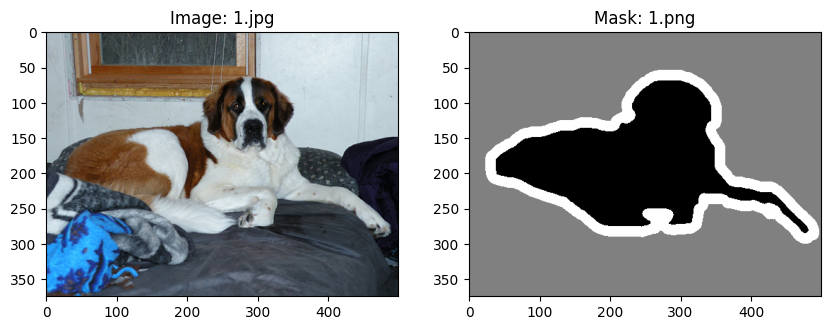

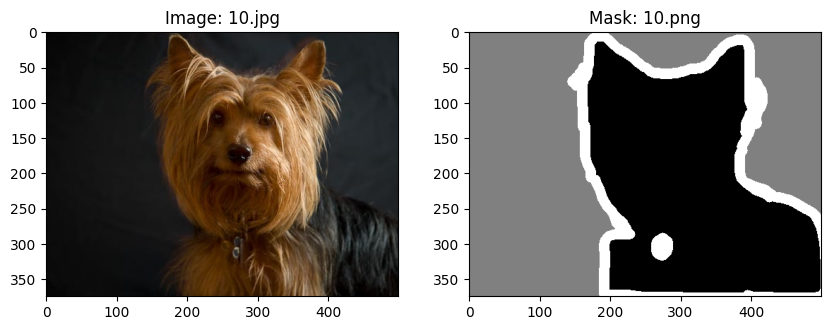

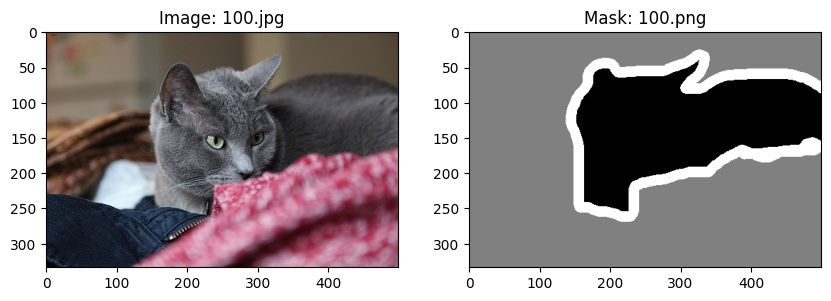

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths
images_path = '/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/images'
masks_path = '/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/masks'

# Get sorted file lists
image_files = sorted(os.listdir(images_path))
mask_files = sorted(os.listdir(masks_path))

# Display first 3 images and masks
for i in range(3):
    image_file = image_files[i]
    mask_file = mask_files[i]
    
    image = mpimg.imread(os.path.join(images_path, image_file))
    mask = mpimg.imread(os.path.join(masks_path, mask_file))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title(f"Image: {image_file}")
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f"Mask: {mask_file}")
    plt.show()


### 1.3 Preprocess the Data:


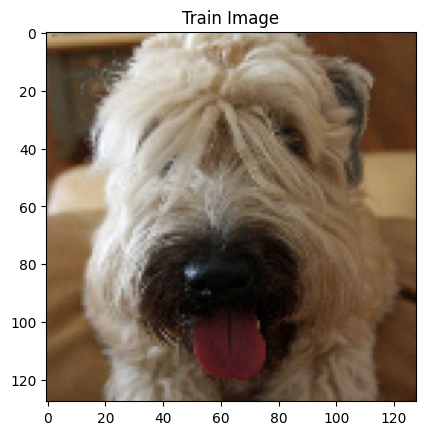

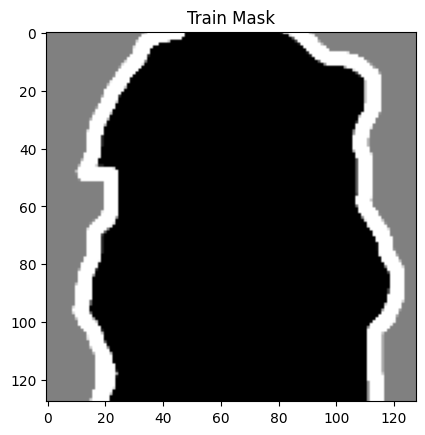

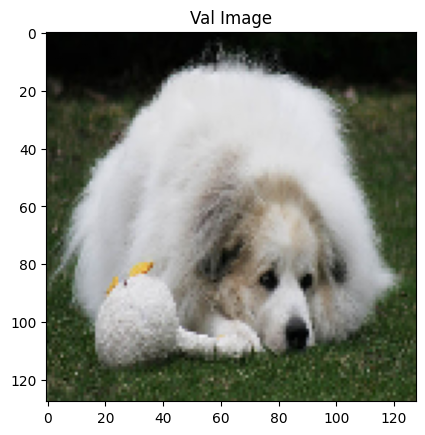

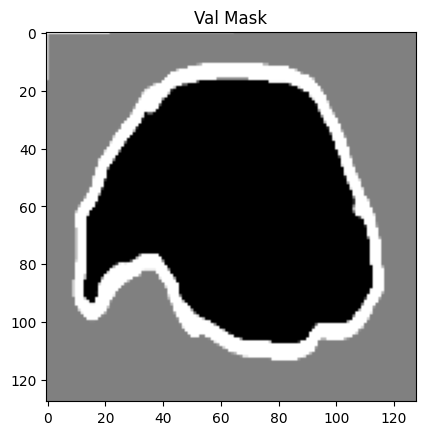

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

# Resize and normalize images
def resize_and_scale(img, size=(128, 128)):
    img_resized = cv2.resize(img, size)
    img_scaled = img_resized / 255.0
    return img_scaled

# Process images and masks
images_processed = [resize_and_scale(mpimg.imread(os.path.join(images_path, img))) for img in image_files]
masks_processed = [resize_and_scale(mpimg.imread(os.path.join(masks_path, msk)), size=(128, 128)) for msk in mask_files]

# Split data into train/val sets
train_imgs, val_imgs, train_msks, val_msks = train_test_split(images_processed, masks_processed, test_size=0.3, random_state=41)

# Show a training image and mask
plt.imshow(train_imgs[0])
plt.title("Train Image")
plt.show()
plt.imshow(train_msks[0], cmap='gray')
plt.title("Train Mask")
plt.show()

# Show a validation image and mask
plt.imshow(val_imgs[0])
plt.title("Val Image")
plt.show()
plt.imshow(val_msks[0], cmap='gray')
plt.title("Val Mask")
plt.show()


In [3]:
# Output the size of the dataset
print(f"Number of training images: {len(train_imgs)}")
print(f"Number of validation images: {len(val_imgs)}")
print(f"Number of training masks: {len(train_msks)}")
print(f"Number of validation masks: {len(val_msks)}")
print(f"Shape of validation images: {val_imgs[0].shape}")
print(f"Shape of validation masks: {val_msks[0].shape}")


Number of training images: 3773
Number of validation images: 1617
Number of training masks: 3773
Number of validation masks: 1617
Shape of validation images: (128, 128, 3)
Shape of validation masks: (128, 128)


## 2 Baseline Methods (10 points)


### 2.1 Implement Baseline Segmentation:

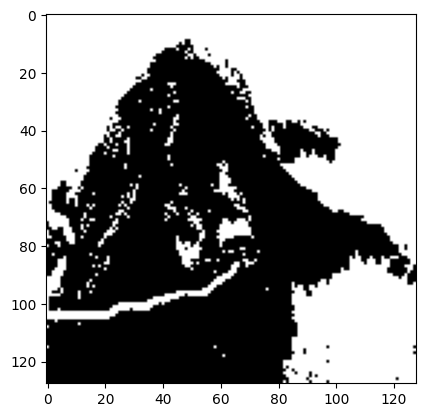

In [4]:
import cv2 as cv
import numpy as np

def segment_image_with_kmeans(input_image, num_clusters=2, termination_criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)):
    # Scale image
    scaled_image = (input_image * 255).astype(np.uint8)
    # Convert to grayscale
    grayscale_image = cv.cvtColor(scaled_image, cv.COLOR_BGR2GRAY)
    # Reshape for k-means
    pixel_values = grayscale_image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    # Apply k-means
    _, labels, cluster_centers = cv.kmeans(pixel_values, num_clusters, None, termination_criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    cluster_centers = np.uint8(cluster_centers)
    labels = labels.flatten()
    # Create segmented image
    segmented_image = cluster_centers[labels]
    segmented_image = segmented_image.reshape(grayscale_image.shape)
    
    # Create boundary image
    boundary_image = np.zeros_like(segmented_image)
    boundary_image[segmented_image == cluster_centers.max()] = 255  # White for boundary
    boundary_image[segmented_image != cluster_centers.max()] = 0    # Black for other
    
    return boundary_image

# Segment 12th training image
segmented_output = segment_image_with_kmeans(train_imgs[11])
plt.imshow(segmented_output, cmap='gray')
plt.show()


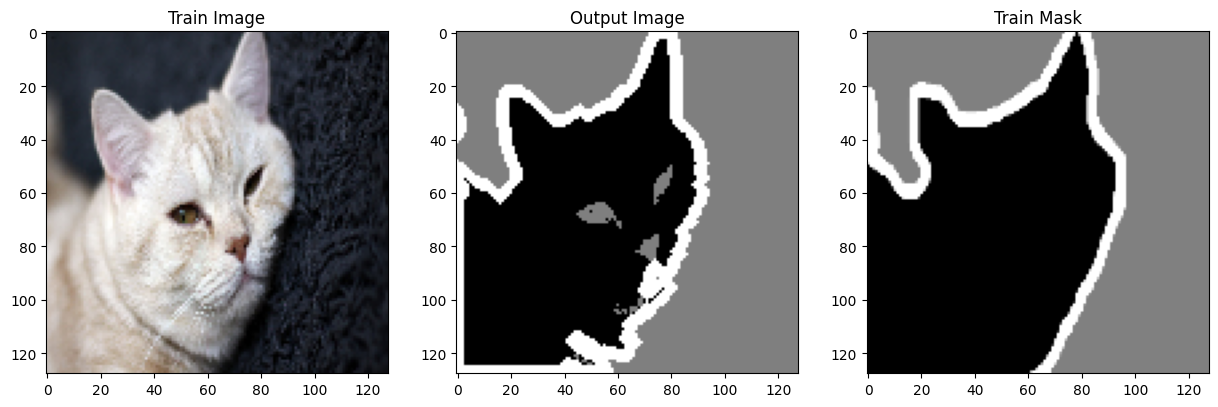

Dice Score: 61.24%


In [5]:
import cv2 as cv
import numpy as np

def draw_grey_margin(image, margin_length=2):
    margin_image = image.copy()
    margin_image[margin_image == 0] = 127
    margin_image[margin_image == 255] = 0
    contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(margin_image, contours, -1, (255), margin_length)
    return margin_image

def calculate_dice_score(image_a, image_b):
    intersection = np.logical_and(image_a, image_b).sum()
    dice_score = (2. * intersection) / (image_a.size + image_b.size)
    return dice_score

img_index = 10
segmented_output = segment_image_with_kmeans(train_imgs[img_index])
output_image = draw_grey_margin(segmented_output, 3)
score = calculate_dice_score(train_msks[img_index], output_image)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(train_imgs[img_index], cmap='gray')
plt.title('Train Image')

plt.subplot(1, 3, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Output Image')

plt.subplot(1, 3, 3)
plt.imshow(train_msks[img_index], cmap='gray')
plt.title('Train Mask')

plt.show()

print(f"Dice Score: {score*100:.2f}%")



##### Loop function

In [6]:
def calculate_avg_dice_score(val_imgs, val_msks):
    total_dice_score = 0
    num_images = len(val_imgs)
    for i in range(num_images):
        try:
            segmented_output = segment_image_with_kmeans(val_imgs[i])
            if len(segmented_output.shape) == 3 and segmented_output.shape[2] == 1:
                segmented_output = segmented_output[:, :, 0]
            output_image = draw_grey_margin(segmented_output, 3)
            score = calculate_dice_score(val_msks[i], output_image)
            total_dice_score += score
            # print(f"Dice Score for image {i+1}: {score*100:.2f}%")
        except cv.error as e:
            print(f"Skipping image {i+1} due to error: {e}")
    
    avg_dice_score = total_dice_score / num_images
    return avg_dice_score



##### Result

In [7]:
avg_dice = calculate_avg_dice_score(val_imgs, val_msks)
print(f"Average Dice Score: {avg_dice*100:.2f}%")

Skipping image 631 due to error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

Skipping image 747 due to error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspeci

### 2.2  Analyze Results:


## 3. Model Implementation (30 points)  
### 3.1 Choose a Model:


In [8]:
!pip3 install unet
!pip3 install tensorflow


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

/Users/bohan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
def load_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [128, 128])
    mask = tf.cast(mask, tf.uint8)

    return image, mask

image_path = "/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/images/1.jpg"
mask_path = "/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/masks/1.png"

image, mask = load_image(image_path, mask_path)
print(f"Image shape: {image.shape}, dtype: {image.dtype}")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")


Image shape: (128, 128, 3), dtype: <dtype: 'float32'>
Mask shape: (128, 128, 1), dtype: <dtype: 'uint8'>


In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Assuming train_dataset and test_dataset are created using image and mask
train_dataset = tf.data.Dataset.from_tensor_slices((image, mask))
test_dataset = tf.data.Dataset.from_tensor_slices((image, mask))


print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of training images: 128
Number of test images: 128


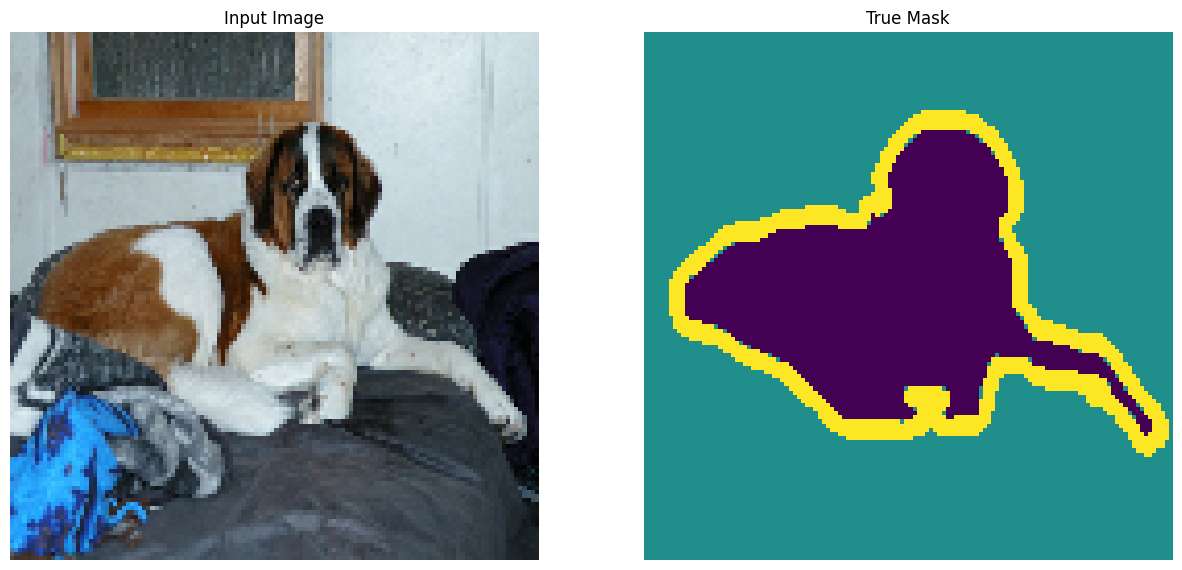

In [26]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   if display_list[i].ndim == 3:
       plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   else:
       raise ValueError(f"Expected image array to have rank 3 (single image). Got array with shape: {display_list[i].shape}")
   plt.axis("off")
 plt.show()

display([image, mask])

In [50]:
import torch
from torchvision import models, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
        self.mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

transform = transforms.Compose([
    transforms.ToTensor()
])

image_dir = "/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/images"
mask_dir = "/Users/bohan/Desktop/ECSE_415/ECSE415/Oxford/train/masks"

# Create a dataset and DataLoader
train_dataset = CustomDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

print((train_loader))


In [56]:
# Iterate over the DataLoader
for images, masks in train_loader:
    # images and masks are now unpacked from the DataLoader
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of masks shape: {masks.shape}")
    # You can now process the images and masks as needed
    # For example, display the first image and mask in the batch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].squeeze(), cmap='gray')  # Assuming masks are single-channel
    plt.title("Mask")
    plt.axis("off")
    
    plt.show()
    break  # Remove this break to process all batches

RuntimeError: stack expects each tensor to be equal size, but got [3, 332, 500] at entry 0 and [3, 406, 480] at entry 1

In [53]:
help(train_loader)

Help on DataLoader in module torch.utils.data.dataloader object:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+_T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~_T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: Optional[int] = None, persistent_workers: bool = False, pin_memory_device: str = '')
 |  
 |  Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-proces

In [55]:
# Run data type <torch.utils.data.dataloader.DataLoader object at 0x3a75e45e0>
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)

model = models.segmentation.deeplabv3_resnet50(pretrained=True)

# Freeze early layers
for param in model.backbone.parameters():
    param.requires_grad = False

# Modify the classifier for your number of classes
num_classes = 2  # Example: binary segmentation
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optionally, use a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop (simplified)
num_epochs = 10  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    scheduler.step()

RuntimeError: stack expects each tensor to be equal size, but got [3, 357, 500] at entry 0 and [3, 378, 500] at entry 1